In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
%matplotlib inline
sns.set()
np.random.seed(123)

In [2]:
def load_n_prep(name):
    df = pd.read_json(os.path.join('{}.json'.format(name)))
    df.set_index('id', inplace=True)
    df['ingredients_count'] = df['ingredients'].apply(lambda x: len(x))
    df['ingredients_word_count'] = df['ingredients'].apply(lambda ingredients: [len(i.split()) for i in ingredients])
    df['ingredients'] = df['ingredients'].apply(lambda ingredients: ' '.join(ingredients)) #ingredients of two words can get lost
    return df

In [3]:
train = load_n_prep('train')
train.head()

,cuisine,ingredients,ingredients_count,ingredients_word_count
id,,,,
10259,greek,romaine lettuce black olives grape tomatoes ga...,9,"[2, 2, 2, 1, 1, 2, 1, 2, 3]"
25693,southern_us,plain flour ground pepper salt tomatoes ground...,11,"[2, 2, 1, 1, 3, 1, 1, 2, 3, 1, 2]"
20130,filipino,eggs pepper salt mayonaise cooking oil green c...,12,"[1, 1, 1, 1, 2, 2, 3, 2, 2, 2, 1, 2]"
22213,indian,water vegetable oil wheat salt,4,"[1, 2, 1, 1]"
13162,indian,black pepper shallots cornflour cayenne pepper...,20,"[2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, ..."


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39774 entries, 10259 to 2362
Data columns (total 4 columns):
cuisine                   39774 non-null object
ingredients               39774 non-null object
ingredients_count         39774 non-null int64
ingredients_word_count    39774 non-null object
dtypes: int64(1), object(3)
memory usage: 1.5+ MB


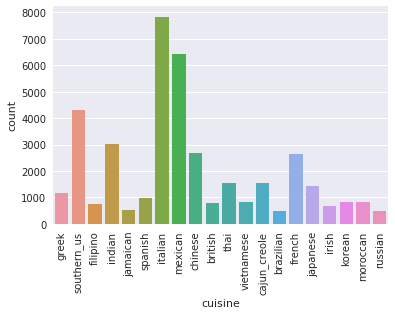

In [5]:
sns.countplot(train.cuisine);
plt.xticks(rotation=90);

### The labels are very unballanced !

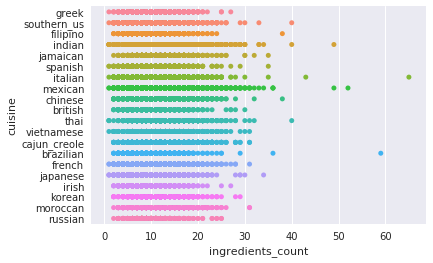

In [6]:
sns.stripplot(x="ingredients_count", y="cuisine", data=train, jitter=False);

### ingredients_count > 35/40 look like outliers

In [7]:
train[train.ingredients_count > 40]

,cuisine,ingredients,ingredients_count,ingredients_word_count
id,,,,
49282,mexican,condensed cream of chicken soup pepper refried...,49,"[5, 1, 2, 4, 2, 5, 1, 3, 3, 2, 2, 1, 2, 2, 2, ..."
3885,italian,fettucine fresh marjoram minced garlic olive o...,65,"[1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 1, 2, 1, 3, ..."
2253,indian,white vinegar sparkling lemonade coconut sugar...,49,"[2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 3, 1, 1, 1, 1, ..."
13049,mexican,vanilla ice cream lime garlic powder zucchini ...,52,"[3, 1, 2, 1, 1, 2, 3, 1, 2, 2, 3, 2, 1, 1, 2, ..."
13430,brazilian,marshmallows fresh corn cheddar cheese shredde...,59,"[1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, ..."
29216,italian,eggs warm water pepper dried basil unsalted bu...,43,"[1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, ..."


# explore some ingredients data

In [8]:
all_ingredients = ' '.join([ings for i, ings in train.ingredients.iteritems()])

all_ingredients[:300]

'romaine lettuce black olives grape tomatoes garlic pepper purple onion seasoning garbanzo beans feta cheese crumbles plain flour ground pepper salt tomatoes ground black pepper thyme eggs green tomatoes yellow corn meal milk vegetable oil eggs pepper salt mayonaise cooking oil green chilies grilled '

In [9]:
set(re.findall(r'\s*(oz|ounc|ounce|pound|lb|inch|inches|kg|to|\d|[^\w])\s*[^a-z]', all_ingredients))

{' ',
 '!',
 '%',
 '&',
 "'",
 '(',
 ')',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '7',
 '8',
 '9',
 'inch',
 'lb',
 'ounc',
 'oz',
 'pound',
 'to',
 '®',
 '€',
 '™'}

In [10]:
set(re.findall(r'[^\w\s]', all_ingredients))

{'!', '%', '&', "'", '(', ')', ',', '-', '.', '/', '®', '’', '€', '™'}

In [11]:
set(re.findall(r'[^A-Za-z\s]', all_ingredients)) - set(re.findall(r'[^\w\s]', all_ingredients))

{'0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'â',
 'ç',
 'è',
 'é',
 'í',
 'î',
 'ú'}

In [12]:
re.findall(r'\w+\s?\d+\s?\w+', all_ingredients)

['10 oz',
 'style 4 cheese',
 'style 4 cheese',
 'style 4 cheese',
 'style 4 cheese',
 'Greek 100 blackberry',
 'sodium 95',
 'syrup 7 Up',
 'onions 40',
 'crust 40',
 'sauc 8 ounc',
 'parsley 25',
 'Shredded 4 Cheese',
 'sodium 96',
 'sauce 33',
 'salt 95',
 '15 oz',
 '10 oz',
 'basil 33',
 'onions 40',
 'Bengali 5 Spice',
 '15 oz',
 'style 4 cheese',
 'milk 40',
 'Bengali 5 Spice',
 'Bengali 5 Spice',
 '15 oz',
 '14 oz',
 '10 oz',
 'Tipo 00 flour',
 '14 oz',
 'cheese 40',
 'onions 33',
 'asparagus 33',
 'juice 40',
 'cheese 25',
 'v 8 juice',
 'v8 comino',
 '10 oz',
 'butter 40',
 'V8 Juice',
 'extract 7 Up',
 'salt 95',
 'pepper 33',
 'licor 43 ice',
 'sauce 40',
 'leaves 33',
 'onion 40',
 'rice 25',
 'Shredded 4 Cheese',
 'pepper 2 1',
 'to 3 lb',
 'sugar 7 Up',
 'tomatoes 40',
 'Bengali 5 Spice',
 'style 4 cheese',
 'vinegar 7 Up',
 'salt 2 1',
 'to 3 lb',
 'onions 40',
 '10 oz',
 'style 4 cheese',
 'cheese 40',
 'v8 salt',
 'kernels 95',
 'style 4 cheese',
 'style 4 cheese']

In [13]:
print(np.max(train.ingredients_word_count.apply(lambda a: np.max(a))))
print(np.median(train.ingredients_word_count.apply(lambda a: np.median(a))))
print(np.mean(train.ingredients_word_count.apply(lambda a: np.mean(a))))
print(np.mean(train.ingredients_word_count.apply(lambda a: np.std(a))))
print(np.min(train.ingredients_word_count.apply(lambda a: np.min(a))))

11
2.0
1.8854256946167263
0.6879890785250199
1


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import Imputer, StandardScaler, RobustScaler
import xgboost as xgb
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier
import datetime
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import os
import nltk

In [15]:
import multiprocessing
def model_run(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train) 
    test_pred = model.predict(X_test)

    train_score = metrics.accuracy_score(y_train, train_pred)
    test_score = metrics.accuracy_score(y_test, test_pred)

    return train_score, test_score

def test_on_train(model, X, y):
    input_to_multi = []
    start = datetime.datetime.now()
#     for train_index, test_index in RepeatedStratifiedKFold(n_splits=5, n_repeats=4, random_state=123).split(X, y):
    for train_index, test_index in StratifiedKFold(n_splits=5,random_state=123).split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        input_to_multi.append([model, X_train, X_test, y_train, y_test])

    with multiprocessing.Pool() as p:
        KFold_results = p.starmap(model_run, input_to_multi)


    print(datetime.datetime.now() - start)
    return pd.DataFrame(KFold_results,
                        columns=['train_score', 'test_score']).mean(axis=0)

In [16]:
from nltk.stem.snowball import SnowballStemmer
from nltk import tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
    
class StemmedCountVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        stemmer = SnowballStemmer("english")
        stops = set(stopwords.words("english"))
        return lambda doc: ([stemmer.stem(w) for w in analyzer(re.sub("[^\w\s]", "", doc)) if w not in stops])
    
# out_index = train[train.ingredients_count > 40].index
X = train.ingredients #.drop(out_index)
y = train.cuisine #.drop(out_index)

model = Pipeline([
#     ('bag_of_words', CountVectorizer(tokenizer=text_process(), stop_words='english')),
    ('bag_of_words', StemmedCountVectorizer(ngram_range=(1, 2), stop_words='english')),

#     ('tfidf', TfidfVectorizer(stop_words='english')),
    ('logreg', LogisticRegression(penalty='l1', C=10, solver='saga', max_iter=1000))
#     ('logreg', OneVsRestClassifier(LogisticRegression(penalty='l2',C=10, max_iter=1000)))
#     ('forest', RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2,
#                                       min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto',
#                                       max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None,
#                                       bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0,
#                                       warm_start=False, class_weight=None))
#     ('svm', OneVsRestClassifier(SVC(C=100, coef0=1)))
#     ('boost', GradientBoostingClassifier()) #best scores
#     ('xgb', xgb.XGBClassifier(max_depth=6, learning_rate=0.01, n_estimators=100,
#                               objective='multi:softmax', booster='gbtree', n_jobs=-1))
])

[nltk_data] Downloading package stopwords to /home/ariel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
np.random.seed(123)
print(datetime.datetime.now())
# test_on_train(model, X, y)
# x_train, x_test, y_train, y_test = train_test_split(X, pd.get_dummies(y), stratify= pd.get_dummies(y))
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify= y)
model.fit(x_train, y_train)
train_pred = model.predict(x_train) 
test_pred = model.predict(x_test)

print(metrics.accuracy_score(y_train, train_pred))
print(metrics.accuracy_score(y_test, test_pred))


print(datetime.datetime.now())

2018-09-18 17:41:04.608945


/home/ariel/venv/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [ ]:
for i in [30, 35, 40, 100]:
    print(i)
    out_index = train[train.ingredients_count > i].index
    X = train.ingredients.drop(out_index)
    y = train.cuisine.drop(out_index)
    print(test_on_train(model, X, y))

In [ ]:
# 0.9837412001340932
# 0.791331456154465

In [ ]:
params = [
#     {'logreg__estimator__C':[0.001, 0.01, 0.1, 1, 10, 100],
#      'logreg__estimator__penalty':['l2'],
#      'logreg__estimator__solver':['newton-cg', 'lbfgs',  'sag']
#     },
    {'bag_of_words__ngram_range':[(1,1), (1,2), (1,3)],
     'bag_of_words__binary':[True, False]
#     'logreg__estimator__C':[0.1, 0.5, 1, 5, 10],
#      'logreg__estimator__class_weight':[None, 'weighted'],
#      'logreg__estimator__penalty':['l2', 'l1'],
     'logreg__C':[0.1, 0.5, 1, 5, 10],
     'logreg__class_weight':[None, 'weighted'],
     'logreg__penalty':['l2', 'l1'],
    }
         ]
GCV = GridSearchCV(model, params, cv=5, n_jobs=4, verbose=2)
GCV.fit(X, pd.get_dummies(y))

In [ ]:
print(GCV.best_score_)
GCV.best_params_

### count the number of words in each ingridiant for the n_grams //Done
# Try to find outliers in num of ingridiants
# try plying with the CountVectorizer/TFIDF params to drop outlier ingridiants
# drop corr features
# Param CV search
### Toknizer + stemmer //Done
# Word2Vec: http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/

# Find corr features in text Vectorizer

In [ ]:
tfidf_transformed_data = StemmedCountVectorizer(stop_words='english').fit_transform(X)

In [ ]:
corr = pd.DataFrame(tfidf_transformed_data.toarray()).corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
tfidf_transformed_data

In [ ]:
def log_transform_skewed(data, skew_value):
    X = data.copy()
    numeric_feats = X.select_dtypes(exclude='object').columns

    skewed_feats = X[numeric_feats].apply(stats.skew) #compute skewness
    skewed_feats = skewed_feats[skewed_feats > abs(skew_value)]
    skewed_feats = skewed_feats.index

    X[skewed_feats] = np.log1p(X[skewed_feats])
    print(len(skewed_feats.columns))
    return X



In [ ]:
tfidf_transformer = StemmedCountVectorizer(stop_words='english').fit(X)
d = tfidf_transformer.transform(X)
cols =tfidf_transformer.get_feature_names()

pd.DataFrame(d.toarray(), columns = cols)
log_transform_skewed()